In [47]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order

In [48]:
base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\comparison\\'
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'
files = ['s0_s1_3600.txt','s4_3600.txt','s5_s6_s3_3600.txt', 's2a_3600.txt']

In [49]:
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [50]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [51]:
def translate(content, limit):
    line = dict()
    line['source'] = content[0]
    line['instance'] = int(content[1])
    line['best_objective'] = float(content[6])
    line['generations'] = int(content[4])
    line['restarts'] = int(content[5])
    line['n_explored'] = int(float(content[3]))
    line['runtime'] = min(float(content[2]), limit)

    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'GA'
    production_environment = FJSSPInstancesTranslator().translate(line['source'], line['instance'])
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    unique_durations = []
    overall_amount_durations = []
    for duration in base_durations:
        for d in duration:
            if d not in unique_durations and d > 0:
                unique_durations.append(d)
        overall_amount_durations.extend([x for x in duration if x > 0])
    overall_amount_durations = len(overall_amount_durations)
    line['duration_variety'] = (len(unique_durations)/overall_amount_durations)
    return line    

In [52]:
data = []
for file in files:
    content = open(base_path + file, 'r').readlines()
    for values in content:
        line = translate(values.split(';'), 3600)
        data.append(line)

In [53]:
best = dict()
for line in data:
    if line['source']+str(line['instance']) not in best:
        best[line['source']+str(line['instance'])] = line
    elif best[line['source']+str(line['instance'])]['best_objective'] > line['best_objective']:
        best[line['source']+str(line['instance'])] = line

In [54]:
print(len(best))

204


In [55]:
import pandas as pd
df = pd.DataFrame.from_dict(best.values())

In [56]:
df.loc[df['source'] == '6_Fattahi']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
100,6_Fattahi,1,66.0,2,0,45,0.015623,2,2,2.0,4,2.0,1.000000,8.0,3600,GA,0.875000
101,6_Fattahi,2,107.0,0,0,5,0.000000,2,2,1.5,4,2.0,0.750000,7.0,3600,GA,0.833333
102,6_Fattahi,3,221.0,63,0,1265,0.062486,2,3,1.7,6,2.0,0.850000,9.4,3600,GA,0.900000
103,6_Fattahi,4,355.0,2,0,45,0.015622,2,3,1.7,6,2.0,0.850000,9.4,3600,GA,1.000000
104,6_Fattahi,5,119.0,17,0,345,0.031241,2,3,2.0,6,2.0,1.000000,10.0,3600,GA,0.750000
105,6_Fattahi,6,320.0,5,0,105,0.031243,3,3,1.6,9,3.0,0.533333,13.8,3600,GA,0.866667
106,6_Fattahi,7,397.0,3,0,65,0.015623,5,3,2.0,9,3.0,0.400000,15.0,3600,GA,0.944444
107,6_Fattahi,8,253.0,3,0,65,0.015620,4,3,2.0,9,3.0,0.500000,15.0,3600,GA,0.944444
108,6_Fattahi,9,210.0,3,0,65,0.015621,3,3,2.0,9,3.0,0.666667,15.0,3600,GA,0.555556
109,6_Fattahi,10,516.0,3,0,65,0.015621,5,4,1.7,12,3.0,0.340000,17.1,3600,GA,0.850000


In [57]:
df.loc[df['source'] == '5_Kacem']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
96,5_Kacem,1,11.0,195,1,5570,0.499883,5,4,5.0,12,3.000000,1.0,27.000000,3600,GA,0.166667
97,5_Kacem,2,11.0,654,4,55215,15.246434,7,10,7.0,29,2.900000,1.0,49.300000,3600,GA,0.088670
98,5_Kacem,3,7.0,986,4,76235,20.167162,10,10,10.0,30,3.000000,1.0,60.000000,3600,GA,0.060000
99,5_Kacem,4,11.0,2906,19,3198780,3600.000000,10,15,10.0,56,3.733333,1.0,93.333333,3600,GA,0.055357


In [58]:
df.loc[df['source'] == '4_ChambersBarnes']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
72,4_ChambersBarnes,1,963.0,1612,10,1076605,3600.0,11,10,1.0,100,10.0,0.090909,110.0,3600,GA,0.536364
73,4_ChambersBarnes,2,948.0,1762,10,1261705,3600.0,12,10,1.0,100,10.0,0.083333,110.0,3600,GA,0.491667
74,4_ChambersBarnes,3,968.0,1815,9,1478250,3600.0,13,10,1.0,100,10.0,0.076923,110.0,3600,GA,0.453846
75,4_ChambersBarnes,4,919.0,1649,10,1132765,3600.0,12,10,1.0,100,10.0,0.083333,110.0,3600,GA,0.491667
76,4_ChambersBarnes,5,873.0,1657,10,1308325,3600.0,13,10,1.0,100,10.0,0.076923,110.0,3600,GA,0.453846
77,4_ChambersBarnes,6,951.0,1744,10,1154445,3600.0,11,10,1.0,100,10.0,0.090909,110.0,3600,GA,0.536364
78,4_ChambersBarnes,7,946.0,1489,10,1102245,3600.0,12,10,1.0,100,10.0,0.083333,110.0,3600,GA,0.491667
79,4_ChambersBarnes,8,985.0,1436,8,749755,3600.0,11,15,1.0,150,10.0,0.090909,160.0,3600,GA,0.466667
80,4_ChambersBarnes,9,977.0,1316,8,720315,3600.0,12,15,1.0,150,10.0,0.083333,160.0,3600,GA,0.427778
81,4_ChambersBarnes,10,991.0,1227,8,655195,3600.0,13,15,1.0,150,10.0,0.076923,160.0,3600,GA,0.394872


In [59]:
df.loc[df['source'] == '3_DPpaulli']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
120,3_DPpaulli,1,2606.0,1268,7,496240,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.375566
121,3_DPpaulli,2,2364.0,1844,7,582860,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.250000
122,3_DPpaulli,3,2283.0,1478,7,522000,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.165669
123,3_DPpaulli,4,2600.0,1311,7,529460,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.357466
124,3_DPpaulli,5,2356.0,1548,7,583200,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.253012
125,3_DPpaulli,6,2272.0,1644,7,521080,3600.0,5,10,1.0,196,19.600000,0.200,215.600000,3600,GA,0.169661
126,3_DPpaulli,7,2672.0,1385,6,279985,3600.0,8,15,1.0,293,19.533333,0.125,312.533333,3600,GA,0.247253
127,3_DPpaulli,8,2197.0,1197,6,352965,3600.0,8,15,1.0,293,19.533333,0.125,312.533333,3600,GA,0.127119
128,3_DPpaulli,9,2484.0,1296,6,314725,3600.0,8,15,1.0,293,19.533333,0.125,312.533333,3600,GA,0.076142
129,3_DPpaulli,10,2585.0,1306,6,289065,3600.0,8,15,1.0,293,19.533333,0.125,312.533333,3600,GA,0.230769


In [60]:
df.loc[df['source'] == '1_Brandimarte']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
0,1_Brandimarte,1,40.0,269,1,8470,3.983443,6,10,2.000000,55,5.500000,0.333333,66.000000,3600,GA,0.052174
1,1_Brandimarte,2,26.0,3028,21,3518230,3600.000000,6,10,3.500000,58,5.800000,0.583333,78.300000,3600,GA,0.025210
2,1_Brandimarte,3,204.0,705,3,37880,104.975468,8,15,3.000000,150,10.000000,0.375000,180.000000,3600,GA,0.037694
3,1_Brandimarte,4,60.0,1734,12,1480295,3600.000000,8,15,2.000000,90,6.000000,0.250000,102.000000,3600,GA,0.052326
4,1_Brandimarte,5,173.0,1623,10,1314545,3600.000000,4,15,1.500000,106,7.066667,0.375000,116.600000,3600,GA,0.027624
5,1_Brandimarte,6,65.0,1685,7,995580,3600.000000,10,10,3.000000,150,15.000000,0.300000,195.000000,3600,GA,0.018367
6,1_Brandimarte,7,141.0,1773,11,1268700,3600.000000,5,20,3.000000,100,5.000000,0.600000,115.000000,3600,GA,0.067138
7,1_Brandimarte,8,523.0,1099,7,394280,3600.000000,10,20,1.500000,225,11.250000,0.150000,241.875000,3600,GA,0.037267
8,1_Brandimarte,9,324.0,1368,6,477585,3600.000000,10,20,3.000000,240,12.000000,0.300000,276.000000,3600,GA,0.026403
9,1_Brandimarte,10,251.0,1208,6,452505,3600.000000,15,20,3.000000,240,12.000000,0.200000,276.000000,3600,GA,0.022346


In [61]:
df.loc[df['source'] == '0_BehnkeGeiger']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
15,0_BehnkeGeiger,1,93.0,3436,23,3874440,3600.000000,20,10,6.08,50,5.0,0.304000,80.40,3600,GA,0.069079
16,0_BehnkeGeiger,2,94.0,3460,22,4096625,3600.000000,20,10,6.72,50,5.0,0.336000,83.60,3600,GA,0.062500
17,0_BehnkeGeiger,3,92.0,3584,22,4011785,3600.000000,20,10,6.24,50,5.0,0.312000,81.20,3600,GA,0.067308
18,0_BehnkeGeiger,4,99.0,3537,22,4038785,3600.000000,20,10,6.64,50,5.0,0.332000,83.20,3600,GA,0.063253
19,0_BehnkeGeiger,5,94.0,3434,23,4038500,3600.000000,20,10,6.16,50,5.0,0.308000,80.80,3600,GA,0.068182
20,0_BehnkeGeiger,6,136.0,2451,11,1931940,3600.000000,20,20,6.68,100,5.0,0.334000,133.40,3600,GA,0.031437
21,0_BehnkeGeiger,7,136.0,2275,11,1874560,3600.000000,20,20,6.52,100,5.0,0.326000,132.60,3600,GA,0.032209
22,0_BehnkeGeiger,8,133.0,2306,11,1893680,3600.000000,20,20,6.44,100,5.0,0.322000,132.20,3600,GA,0.032609
23,0_BehnkeGeiger,9,135.0,2397,11,1989420,3600.000000,20,20,6.44,100,5.0,0.322000,132.20,3600,GA,0.032609
24,0_BehnkeGeiger,10,140.0,2254,11,1885000,3600.000000,20,20,6.12,100,5.0,0.306000,130.60,3600,GA,0.034314


In [62]:
df.loc[df['source'] == '2a_Hurink_sdata']

,source,instance,best_objective,generations,restarts,n_explored,runtime,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer,duration_variety
138,2a_Hurink_sdata,1,55.0,209,1,4950,0.999763,6,6,1.0,36,6.0,0.166667,42.0,3600,GA,0.250000
139,2a_Hurink_sdata,2,974.0,1662,10,1265185,3600.000000,10,10,1.0,100,10.0,0.100000,110.0,3600,GA,0.590000
140,2a_Hurink_sdata,3,1181.0,1673,10,1213385,3600.000000,5,20,1.0,100,5.0,0.200000,105.0,3600,GA,0.590000
141,2a_Hurink_sdata,4,666.0,255,1,7350,3.389822,5,10,1.0,50,5.0,0.200000,55.0,3600,GA,0.760000
142,2a_Hurink_sdata,5,655.0,944,5,184510,127.907254,5,10,1.0,50,5.0,0.200000,55.0,3600,GA,0.780000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2a_Hurink_sdata,62,1034.0,1520,11,1241460,3600.000000,10,10,1.0,100,10.0,0.100000,110.0,3600,GA,0.630000
200,2a_Hurink_sdata,63,407.0,1600,11,1157780,3600.000000,10,10,1.0,99,9.9,0.100000,108.9,3600,GA,0.383838
201,2a_Hurink_sdata,64,933.0,1642,11,1496360,3600.000000,10,10,1.0,100,10.0,0.100000,110.0,3600,GA,0.610000
202,2a_Hurink_sdata,65,960.0,1854,12,1695395,3600.000000,10,10,1.0,100,10.0,0.100000,110.0,3600,GA,0.660000


In [63]:
def translate_gurobi(columns, limit):
    line = dict()
    line['source'] = columns[0]
    line['instance'] = int(columns[1])
    line['best_objective'] = int(float(columns[2])+0.5)
    line['gap'] = float(columns[3])
    line['status'] = int(columns[4])
    line['n_explored'] = int(float(columns[5]))
    line['runtime'] = float(columns[6])
    line['overall_runtime'] = float(columns[7])
    line['setup_time'] = line['overall_runtime'] - line['runtime']
    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'Gurobi'
    return line    

In [64]:
path_30_min = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\30min_gurobi.txt'
data_30 = []
file = open(path_30_min, 'r')
file_content = file.readlines()
results_30_min = [x.split(';') for x in file_content]
for columns in results_30_min[1:]:
    line = translate_gurobi(columns, 30)
    data_30.append(line)

In [65]:
df_gurobi = pd.DataFrame(data_30)

In [66]:
df_gurobi

,source,instance,best_objective,gap,status,n_explored,runtime,overall_runtime,setup_time,n_machines,n_jobs,average_workstations_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,limit,optimizer
0,0_BehnkeGeiger,1,90,0.000000,2,158083,309.802,309.990282,0.188282,20,10,6.08,50,5.0,0.304000,80.4,30,Gurobi
1,0_BehnkeGeiger,2,91,0.000000,2,175969,220.011,220.229788,0.218788,20,10,6.72,50,5.0,0.336000,83.6,30,Gurobi
2,0_BehnkeGeiger,3,91,0.000000,2,87914,298.821,299.008287,0.187287,20,10,6.24,50,5.0,0.312000,81.2,30,Gurobi
3,0_BehnkeGeiger,4,97,0.041237,9,2042111,1800.017,1800.251823,0.234823,20,10,6.64,50,5.0,0.332000,83.2,30,Gurobi
4,0_BehnkeGeiger,5,91,0.032967,9,2708987,1800.014,1800.357862,0.343863,20,10,6.16,50,5.0,0.308000,80.8,30,Gurobi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,6_Fattahi,16,634,0.000000,2,84328,12.107,12.141869,0.034869,7,8,2.60,24,3.0,0.371429,31.8,30,Gurobi
398,6_Fattahi,17,879,0.000000,2,93502,16.433,16.464900,0.031899,7,8,2.40,32,4.0,0.342857,41.6,30,Gurobi
399,6_Fattahi,18,884,0.000000,2,5883870,705.945,705.991282,0.046282,8,9,2.40,36,4.0,0.300000,45.6,30,Gurobi
400,6_Fattahi,19,1080,0.170370,9,2733911,1800.032,1800.094997,0.062997,8,11,2.30,44,4.0,0.287500,53.2,30,Gurobi


In [67]:
difference = dict()


In [68]:
df_gurobi.loc[df_gurobi['source'] == '1_Brandimarte'].loc[df_gurobi['instance'] == 1]['best_objective'].values[0]


40

In [155]:
for index, row in df.iterrows():
    if row['source']+str(row['instance']) not in difference:
        difference[row['source']+str(row['instance'])] = {
                'source': row['source'], 
                'instance': row['instance'], 
                'best_objective': row['best_objective'],
                'n_machines' : row['n_machines'],
                'n_job' : row['n_jobs'],
                'average_machines_per_operation' : row['average_workstations_per_operation'],
                'n_operations' : row['n_operations'],
                'average_operations_per_job' : row['average_operations_per_job'],
                'beta_flexibility' : row['beta_flexibility'],
                'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
                'duration_variety' : row['duration_variety'],
                'fevals_GA': row['n_explored'],
                'fevals_Gurobi': 0,
                'optimizer': 'GA',
                'difference': 0
            }
    gurobi_entry = df_gurobi.loc[df_gurobi['source'] == row['source']].loc[df_gurobi['instance'] == row['instance']]
    if gurobi_entry['best_objective'].values[0] < row['best_objective']:
            difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'], 
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'], 
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'optimizer': 'Gurobi',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0]
        }
    elif gurobi_entry['best_objective'].values[0] == row['best_objective']:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'], 
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'optimizer': 'Tie',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0]
        }
    else:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'], 
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'optimizer': 'GA',
            'difference': gurobi_entry['best_objective'].values[0] - row['best_objective']
        }

In [156]:
difference

{'1_Brandimarte1': {'source': '1_Brandimarte',
  'instance': 1,
  'best_objective': 40.0,
  'n_machines': 6,
  'n_job': 10,
  'average_machines_per_operation': 2.0,
  'n_operations': 55,
  'average_operations_per_job': 5.5,
  'beta_flexibility': 0.3333333333333333,
  'approximate_max_dissimilarity': 66.0,
  'duration_variety': 0.05217391304347826,
  'fevals_GA': 8470,
  'fevals_Gurobi': 6401,
  'optimizer': 'Tie',
  'difference': 0.0},
 '1_Brandimarte2': {'source': '1_Brandimarte',
  'instance': 2,
  'best_objective': 26.0,
  'n_machines': 6,
  'n_job': 10,
  'average_machines_per_operation': 3.5,
  'n_operations': 58,
  'average_operations_per_job': 5.8,
  'beta_flexibility': 0.5833333333333334,
  'approximate_max_dissimilarity': 78.3,
  'duration_variety': 0.025210084033613446,
  'fevals_GA': 3518230,
  'fevals_Gurobi': 1025776,
  'optimizer': 'GA',
  'difference': 1.0},
 '1_Brandimarte3': {'source': '1_Brandimarte',
  'instance': 3,
  'best_objective': 204.0,
  'n_machines': 8,
  'n

In [157]:
df_diff = pd.DataFrame(difference.values())

In [158]:
df_diff

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,optimizer,difference
0,1_Brandimarte,1,40.0,6,10,2.000000,55,5.500000,0.333333,66.000000,0.052174,8470,6401,Tie,0.0
1,1_Brandimarte,2,26.0,6,10,3.500000,58,5.800000,0.583333,78.300000,0.025210,3518230,1025776,GA,1.0
2,1_Brandimarte,3,204.0,8,15,3.000000,150,10.000000,0.375000,180.000000,0.037694,37880,8325,Tie,0.0
3,1_Brandimarte,4,60.0,8,15,2.000000,90,6.000000,0.250000,102.000000,0.052326,1480295,1074732,Tie,0.0
4,1_Brandimarte,5,173.0,4,15,1.500000,106,7.066667,0.375000,116.600000,0.027624,1314545,354312,Tie,0.0
5,1_Brandimarte,6,65.0,10,10,3.000000,150,15.000000,0.300000,195.000000,0.018367,995580,21745,GA,2.0
6,1_Brandimarte,7,141.0,5,20,3.000000,100,5.000000,0.600000,115.000000,0.067138,1268700,912694,GA,4.0
7,1_Brandimarte,8,523.0,10,20,1.500000,225,11.250000,0.150000,241.875000,0.037267,394280,21626,Tie,0.0
8,1_Brandimarte,9,324.0,10,20,3.000000,240,12.000000,0.300000,276.000000,0.026403,477585,20832,Gurobi,13.0
9,1_Brandimarte,10,251.0,15,20,3.000000,240,12.000000,0.200000,276.000000,0.022346,452505,21203,Gurobi,30.0


In [159]:
df_diff.loc[df_diff['difference'] > 0].groupby('optimizer').count()

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,difference
optimizer,,,,,,,,,,,,,,
GA,25,25,25,25,25,25,25,25,25,25,25,25,25,25
Gurobi,124,124,124,124,124,124,124,124,124,124,124,124,124,124


In [160]:
df_diff.groupby('optimizer').count()

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,difference
optimizer,,,,,,,,,,,,,,
GA,25,25,25,25,25,25,25,25,25,25,25,25,25,25
Gurobi,124,124,124,124,124,124,124,124,124,124,124,124,124,124
Tie,55,55,55,55,55,55,55,55,55,55,55,55,55,55


In [161]:
import seaborn as sns

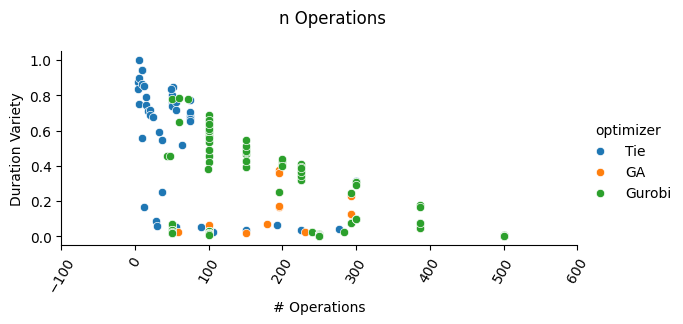

In [228]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

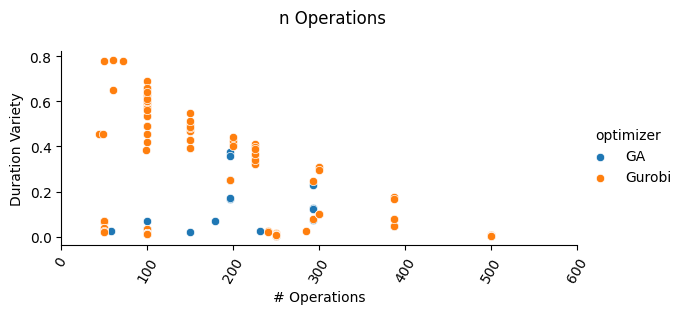

In [229]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] != 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

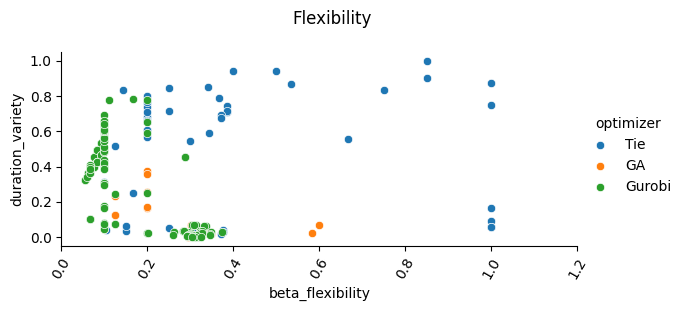

In [163]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('Flexibility')

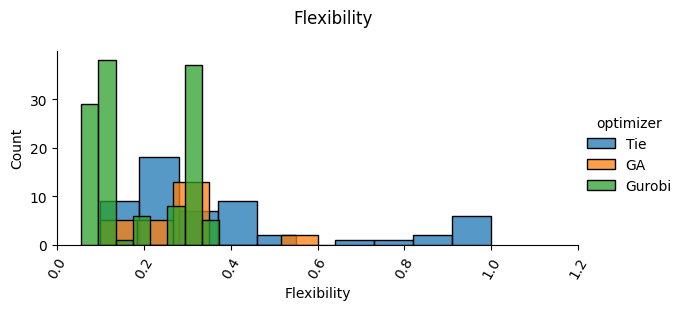

In [235]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

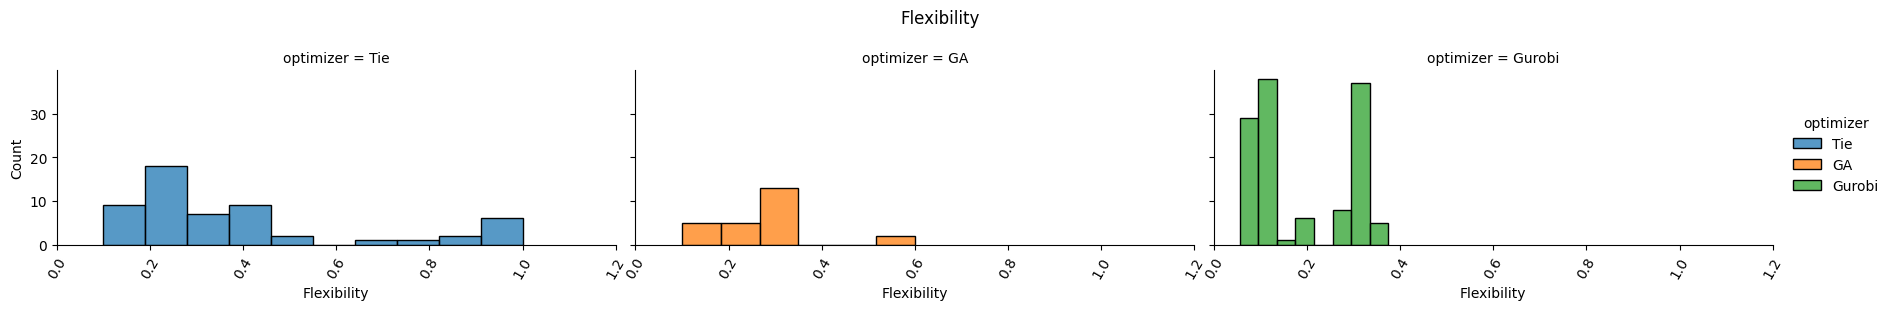

In [234]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

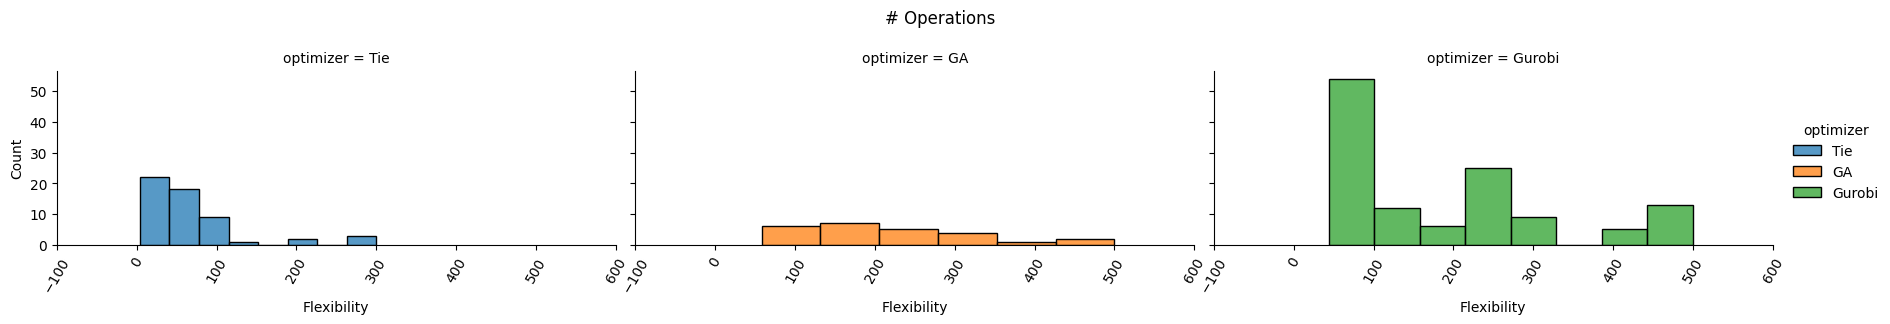

In [233]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

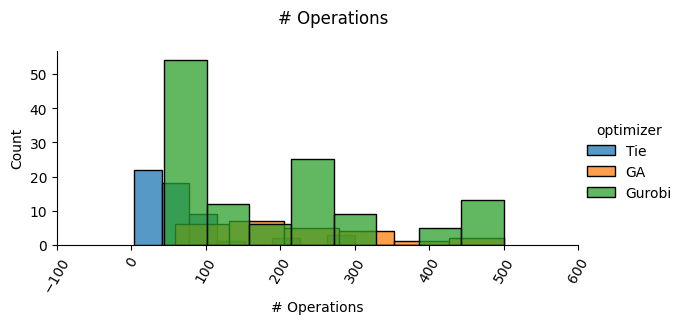

In [236]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

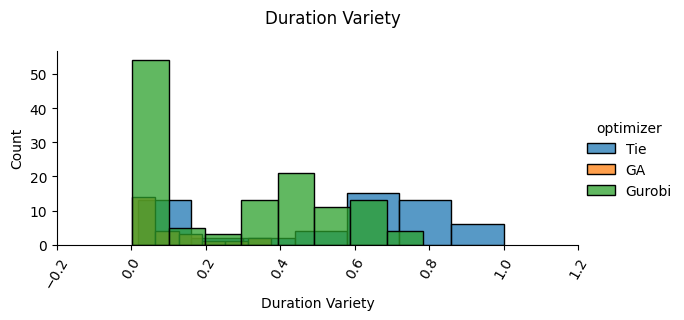

In [237]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

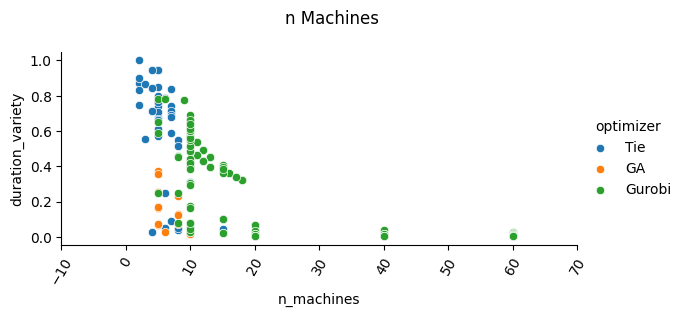

In [164]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("n Machines")
fg.map_dataframe(sns.scatterplot, x='n_machines', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Machines')

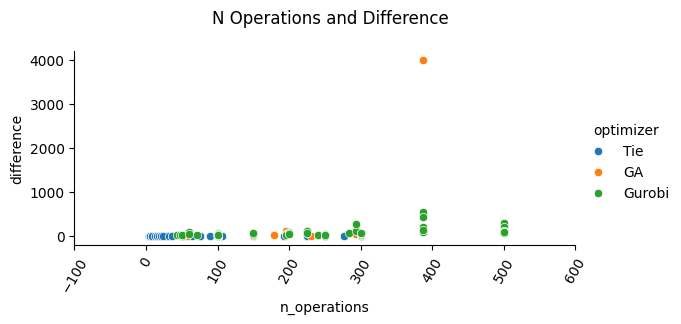

In [165]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("N Operations and Difference")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='difference').add_legend().set_xticklabels(rotation=60)

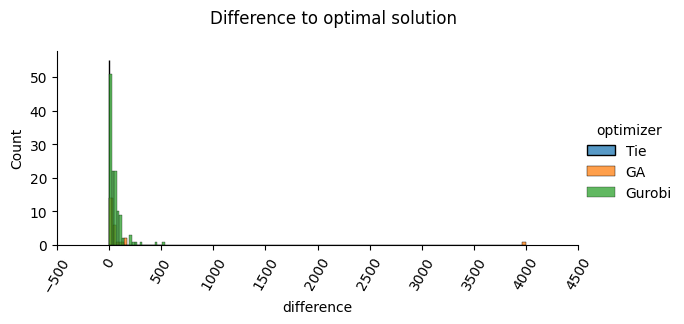

In [166]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference to optimal solution")
fg.map_dataframe(sns.histplot, x='difference').add_legend().set_xticklabels(rotation=60)

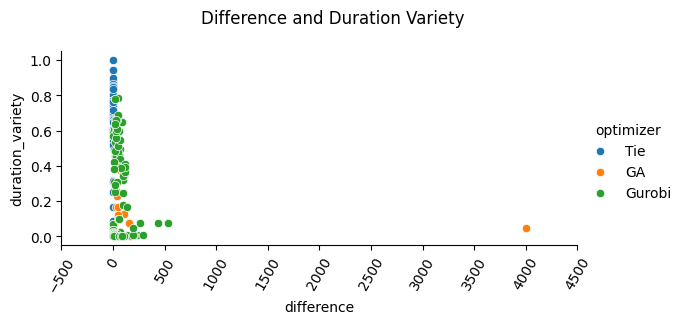

In [167]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Duration Variety")
fg.map_dataframe(sns.scatterplot, x='difference', y='duration_variety').add_legend().set_xticklabels(rotation=60)

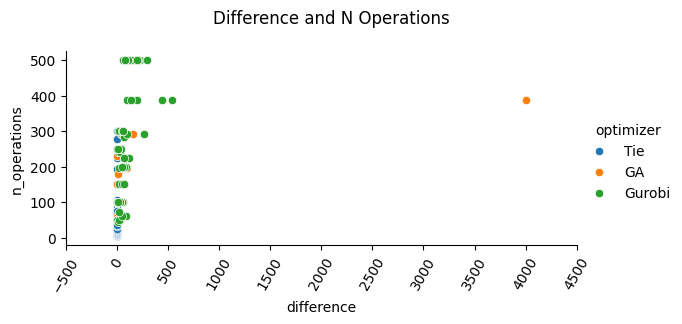

In [168]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_operations').add_legend().set_xticklabels(rotation=60)

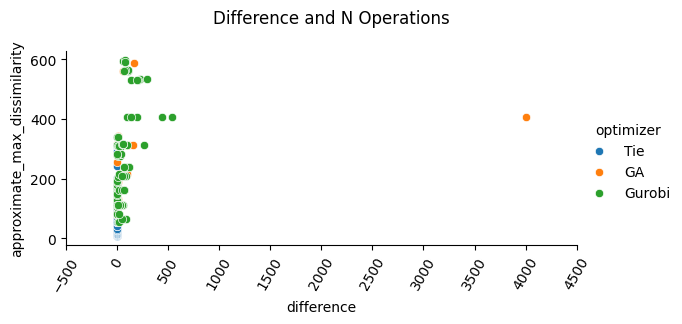

In [169]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='approximate_max_dissimilarity').add_legend().set_xticklabels(rotation=60)

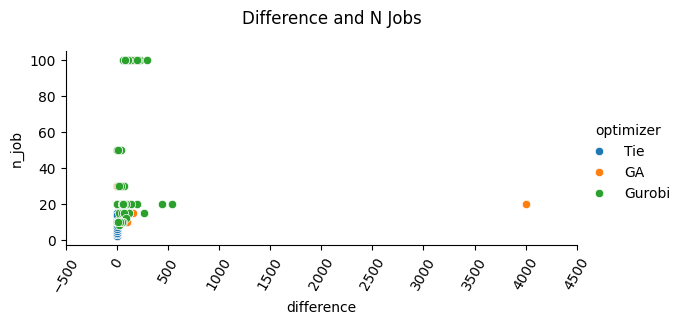

In [170]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Jobs")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_job').add_legend().set_xticklabels(rotation=60)

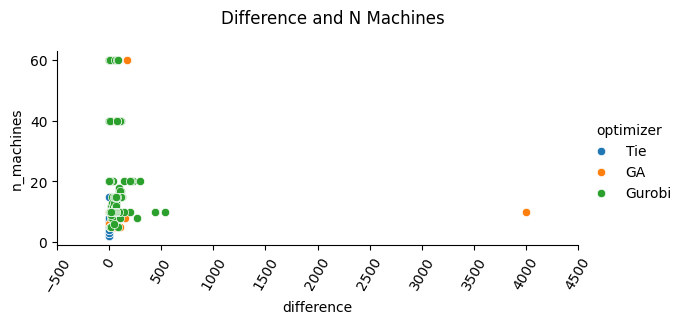

In [171]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Machines")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_machines').add_legend().set_xticklabels(rotation=60)

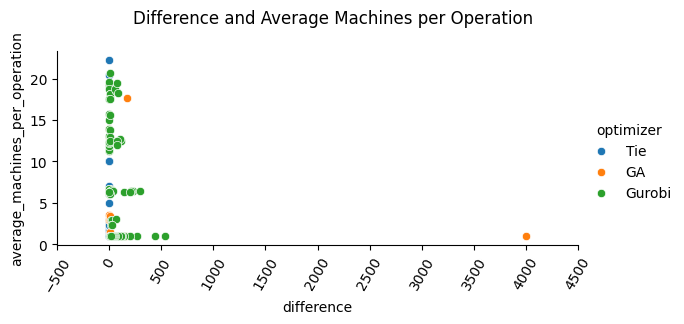

In [172]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='difference', y='average_machines_per_operation').add_legend().set_xticklabels(rotation=60)

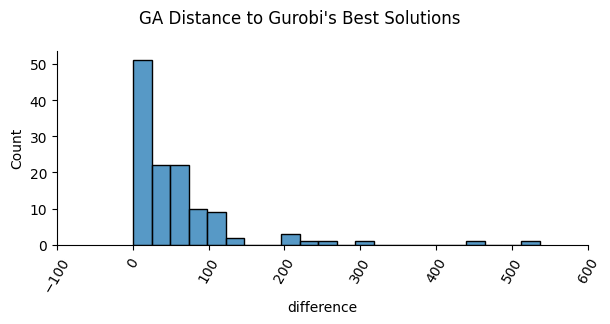

In [173]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Gurobi'], aspect=2)
fg.fig.suptitle("GA Distance to Gurobi's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

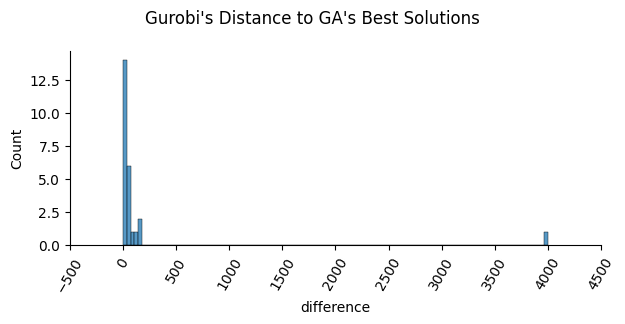

In [174]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'GA'], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

In [175]:
df_diff.loc[df_diff['difference'] > 2000]

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,optimizer,difference
137,3_DPpaulli,18,2965.0,10,20,1.0,387,19.35,0.1,406.35,0.045853,188630,630,GA,4000.0


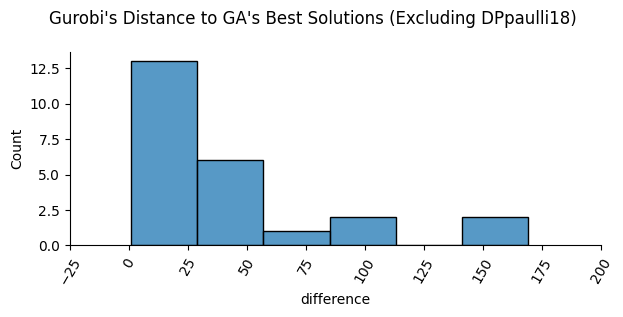

In [176]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') & (df_diff['difference'] < 4000)], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

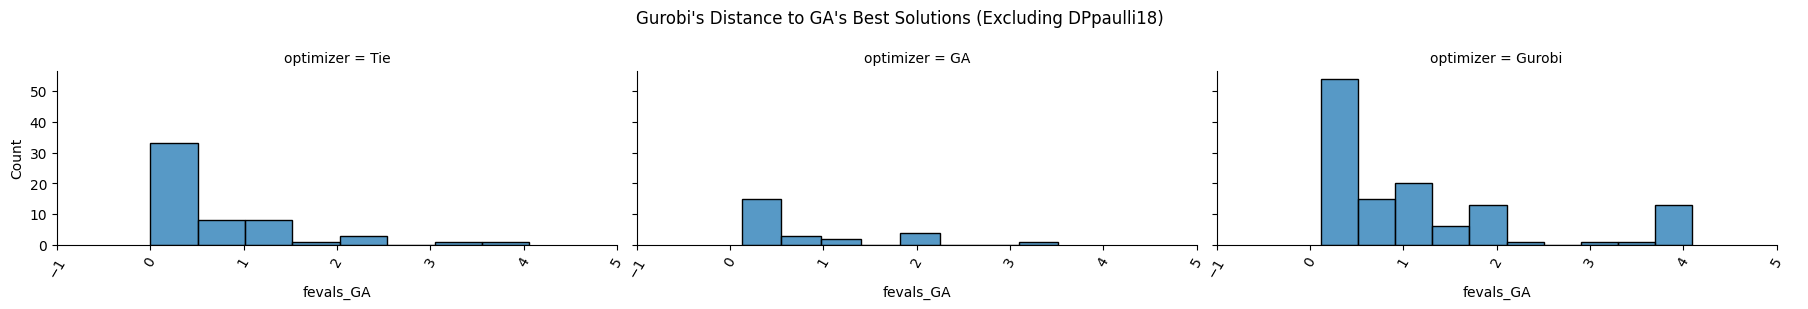

In [193]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_GA',).add_legend().set_xticklabels(rotation=60)

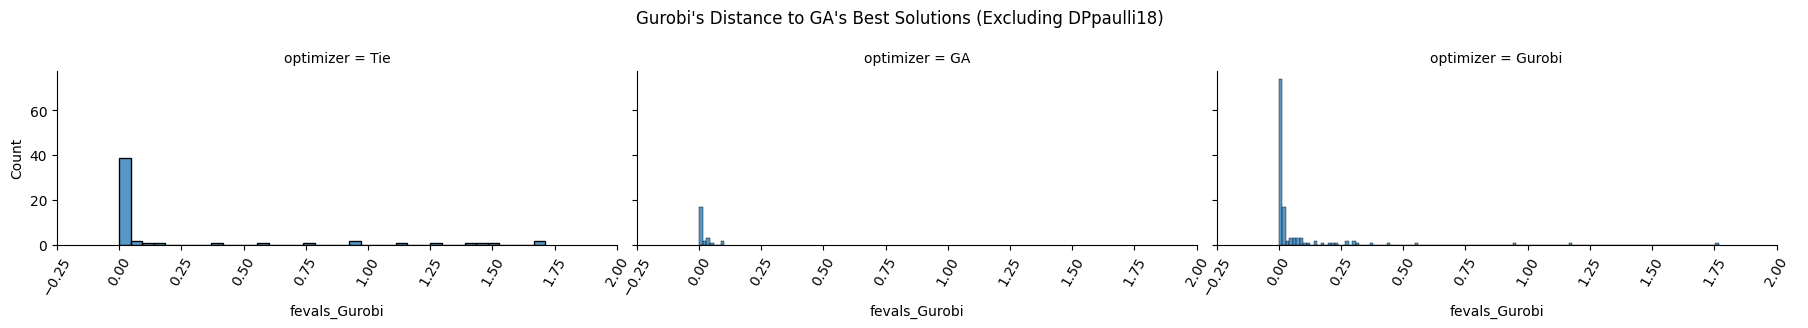

In [194]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_Gurobi',).add_legend().set_xticklabels(rotation=60)

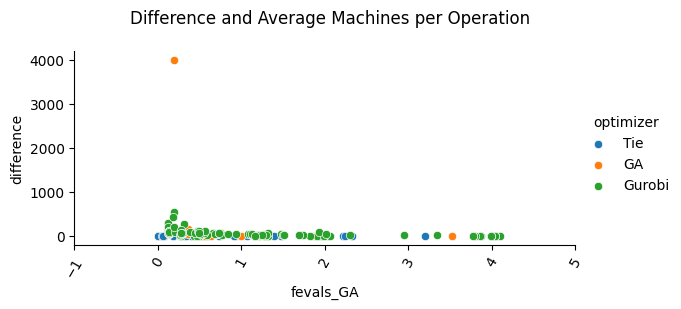

In [185]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

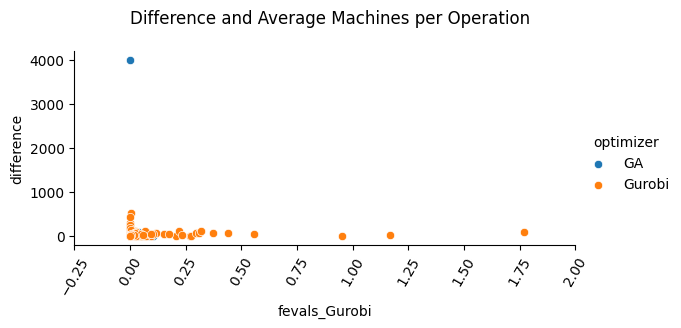

In [187]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_Gurobi', y='difference').add_legend().set_xticklabels(rotation=60)

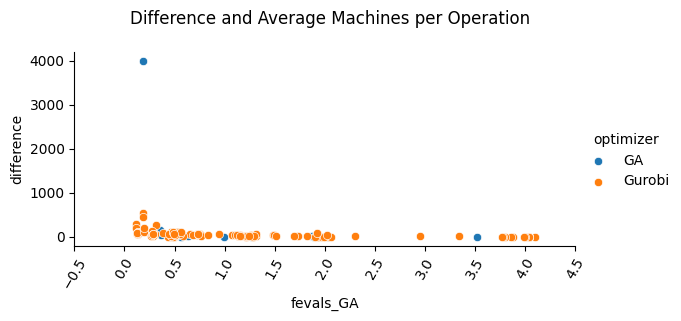

In [189]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

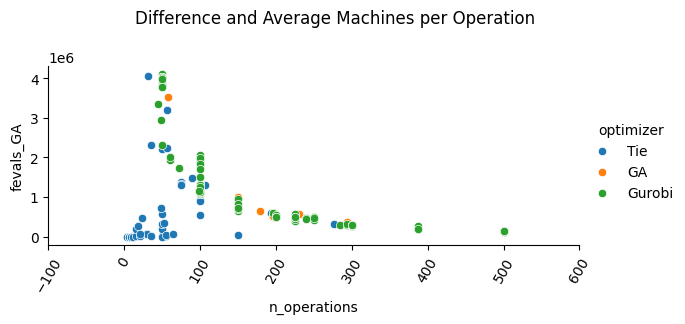

In [198]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA').add_legend().set_xticklabels(rotation=60)

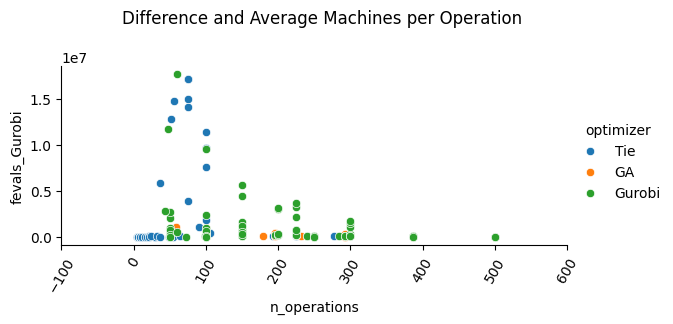

In [197]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi').add_legend().set_xticklabels(rotation=60)

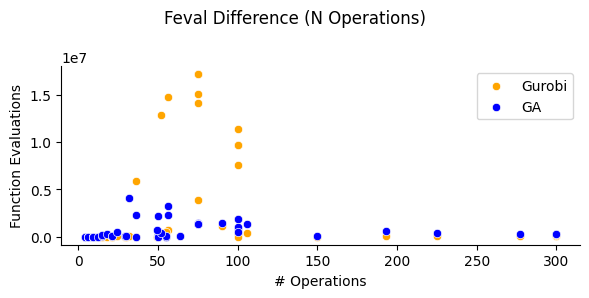

In [226]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], aspect=2)
fg.fig.suptitle("Feval Difference (N Operations)")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('# Operations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

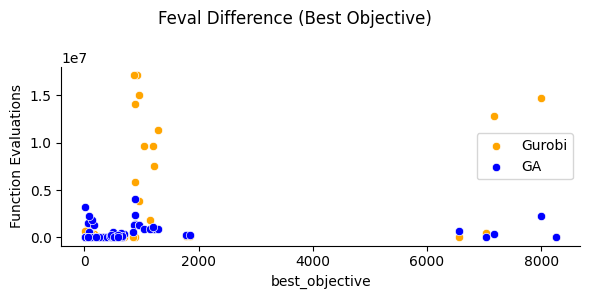

In [221]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Best Objective)")
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

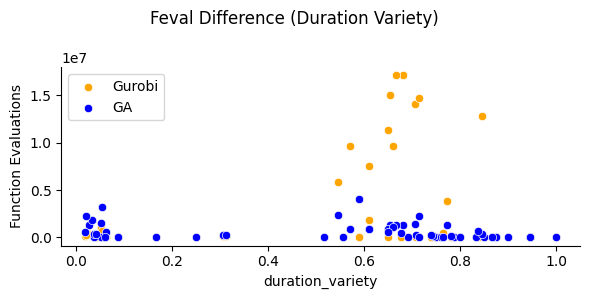

In [222]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Duration Variety)")
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

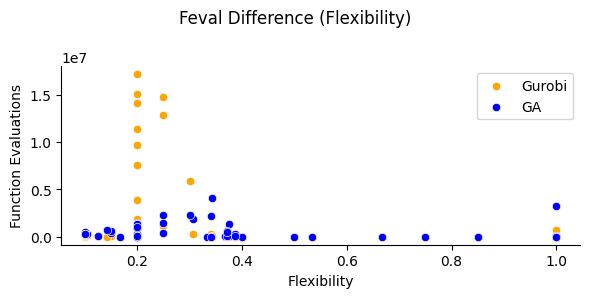

In [224]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Flexibility)")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

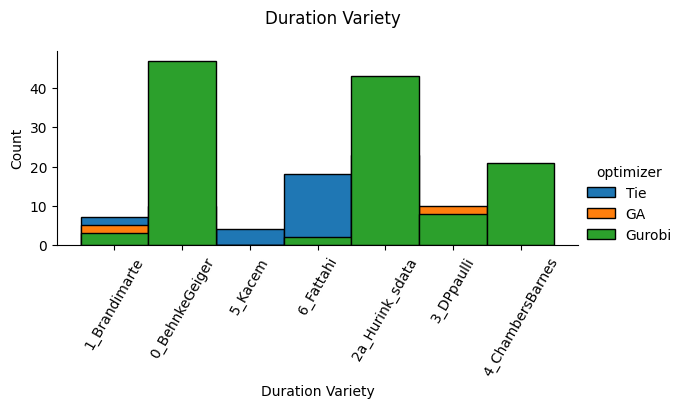

In [244]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='source', alpha=1, ).add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

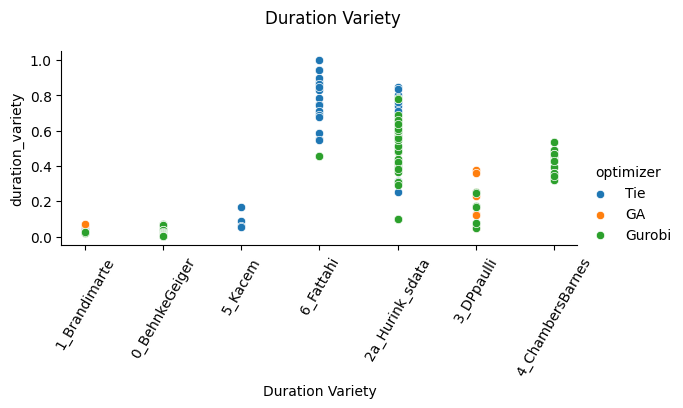

In [259]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.scatterplot, x='source', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

In [177]:
df_diff.sort_values(by=['difference'], ascending=False)

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,optimizer,difference
137,3_DPpaulli,18,2965.0,10,20,1.000000,387,19.350000,0.100000,406.350000,0.045853,188630,630,GA,4000.0
133,3_DPpaulli,14,2862.0,10,20,1.000000,387,19.350000,0.100000,406.350000,0.078720,188450,21095,Gurobi,537.0
136,3_DPpaulli,17,2833.0,10,20,1.000000,387,19.350000,0.100000,406.350000,0.076125,180410,4842,Gurobi,440.0
33,0_BehnkeGeiger,19,838.0,20,100,6.450000,500,5.000000,0.322500,532.250000,0.006514,119035,694,Gurobi,294.0
128,3_DPpaulli,9,2484.0,8,15,1.000000,293,19.533333,0.125000,312.533333,0.076142,314725,12879,Gurobi,264.0
30,0_BehnkeGeiger,16,831.0,20,100,6.470000,500,5.000000,0.323500,532.350000,0.006489,119115,272,Gurobi,230.0
31,0_BehnkeGeiger,17,801.0,20,100,6.400000,500,5.000000,0.320000,532.000000,0.006562,118335,81,Gurobi,205.0
134,3_DPpaulli,15,2923.0,10,20,1.000000,387,19.350000,0.100000,406.350000,0.046883,195810,5262,Gurobi,198.0
34,0_BehnkeGeiger,20,825.0,20,100,6.330000,500,5.000000,0.316500,531.650000,0.006637,118955,504,Gurobi,197.0
95,0_BehnkeGeiger,60,540.0,60,100,17.650000,500,5.000000,0.294167,588.250000,0.002380,126355,503,GA,169.0


In [178]:
pd.options.display.max_rows = 500
df_diff.loc[:, ['source', 'instance', 'optimizer', 'difference']].loc[df_diff['difference'] > 0].sort_values(by=['difference'], ascending=False)

,source,instance,optimizer,difference
137,3_DPpaulli,18,GA,4000.0
133,3_DPpaulli,14,Gurobi,537.0
136,3_DPpaulli,17,Gurobi,440.0
33,0_BehnkeGeiger,19,Gurobi,294.0
128,3_DPpaulli,9,Gurobi,264.0
30,0_BehnkeGeiger,16,Gurobi,230.0
31,0_BehnkeGeiger,17,Gurobi,205.0
134,3_DPpaulli,15,Gurobi,198.0
34,0_BehnkeGeiger,20,Gurobi,197.0
95,0_BehnkeGeiger,60,GA,169.0


In [179]:
df_diff.loc[df_diff['difference'] == 0]

,source,instance,best_objective,n_machines,n_job,average_machines_per_operation,n_operations,average_operations_per_job,beta_flexibility,approximate_max_dissimilarity,duration_variety,fevals_GA,fevals_Gurobi,optimizer,difference
0,1_Brandimarte,1,40.0,6,10,2.000000,55,5.500000,0.333333,66.000000,0.052174,8470,6401,Tie,0.0
2,1_Brandimarte,3,204.0,8,15,3.000000,150,10.000000,0.375000,180.000000,0.037694,37880,8325,Tie,0.0
3,1_Brandimarte,4,60.0,8,15,2.000000,90,6.000000,0.250000,102.000000,0.052326,1480295,1074732,Tie,0.0
4,1_Brandimarte,5,173.0,4,15,1.500000,106,7.066667,0.375000,116.600000,0.027624,1314545,354312,Tie,0.0
7,1_Brandimarte,8,523.0,10,20,1.500000,225,11.250000,0.150000,241.875000,0.037267,394280,21626,Tie,0.0
11,1_Brandimarte,12,508.0,10,30,1.492228,193,6.433333,0.149223,202.600000,0.062500,582920,31020,Tie,0.0
13,1_Brandimarte,14,694.0,15,30,1.559567,277,9.233333,0.103971,291.400000,0.041667,315365,20712,Tie,0.0
24,0_BehnkeGeiger,10,140.0,20,20,6.120000,100,5.000000,0.306000,130.600000,0.034314,1885000,225347,Tie,0.0
55,0_BehnkeGeiger,41,87.0,60,10,22.240000,50,5.000000,0.370667,161.200000,0.018885,557280,114528,Tie,0.0
59,0_BehnkeGeiger,45,87.0,60,10,20.400000,50,5.000000,0.340000,152.000000,0.020588,2220325,263529,Tie,0.0


In [180]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['difference'], ascending=False)

,source,instance,best_objective,optimizer,difference
33,0_BehnkeGeiger,19,838.0,Gurobi,294.0
30,0_BehnkeGeiger,16,831.0,Gurobi,230.0
31,0_BehnkeGeiger,17,801.0,Gurobi,205.0
34,0_BehnkeGeiger,20,825.0,Gurobi,197.0
95,0_BehnkeGeiger,60,540.0,GA,169.0
32,0_BehnkeGeiger,18,821.0,Gurobi,140.0
50,0_BehnkeGeiger,36,578.0,Gurobi,110.0
52,0_BehnkeGeiger,38,552.0,Gurobi,105.0
94,0_BehnkeGeiger,59,530.0,Gurobi,83.0
53,0_BehnkeGeiger,39,555.0,Gurobi,77.0


In [182]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'fevals_GA', 'fevals_Gurobi', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['optimizer'], ascending=False)

,source,instance,best_objective,fevals_GA,fevals_Gurobi,optimizer,difference
15,0_BehnkeGeiger,1,93.0,3874440,158083,Gurobi,3.0
60,0_BehnkeGeiger,46,124.0,1931660,162689,Gurobi,4.0
46,0_BehnkeGeiger,32,264.0,429605,2802,Gurobi,1.0
47,0_BehnkeGeiger,33,264.0,482805,2618,Gurobi,2.0
49,0_BehnkeGeiger,35,258.0,491065,2320,Gurobi,4.0
50,0_BehnkeGeiger,36,578.0,133615,61,Gurobi,110.0
52,0_BehnkeGeiger,38,552.0,133435,31,Gurobi,105.0
53,0_BehnkeGeiger,39,555.0,134375,106,Gurobi,77.0
54,0_BehnkeGeiger,40,575.0,135295,749,Gurobi,71.0
56,0_BehnkeGeiger,42,88.0,3985850,712018,Gurobi,1.0
